### Load required libraries

In [23]:
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats

import pandas as pd
import json
import re

from PIL import Image
import base64

import seaborn as sns

### Retrieve preprocessed drawing session metadata

In [24]:
## define some paths
top_level_dir = '/home/jefan/kiddraw'
path_to_preprocessed_data = 'analysis/museumdraw/preprocessed_data/museumdraw_E1cd_data.csv'

## load in preprocessed csv
x = pd.read_csv(os.path.join(top_level_dir,path_to_preprocessed_data))
x = x.drop(['Unnamed: 0'], axis=1)
print 'Number of sketches in metadata = {}'.format(np.shape(x)[0])
metadata_sketch_count = np.shape(x)[0]

Number of sketches in metadata = 467


### Load VGG feature analysis libraries and scripts

In [25]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import scipy.stats as stats
from scipy.stats import norm
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import linear_model, datasets, neighbors

from sklearn.cluster import AffinityPropagation
from sklearn import metrics

from glob import glob
import os

import embedding as emb
reload(emb)
from embedding import *

In [26]:
# Retrieve sketch paths -- pngs rendered out in another step
def list_files(path, ext='png'):
    result = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

# extract metadata
path_to_sketches = '/home/jefan/kiddraw/analysis/museumdraw/sketches'
sketch_paths = sorted(list_files(path_to_sketches))

## number of sketch paths 
print 'Number of sketch paths = {}'.format(len(sketch_paths))

png_sketch_count = len(sketch_paths)

Number of sketch paths = 467


## extract features

**Dec 28 2017 (updated Jan 14 2018):** <br>
 - From command line, extract features using `extract_features.py`. The default arguments are for the kid's drawings. <br>
 - To extract kid's drawings, just run: `python extract_features.py` <br>
 - To extract (mini verison of) adult drawings, run: `python extract_features.py --data='/data2/jefan/quickDraw/png_mini' --layer_ind=6 --cohort='adult' --spatial_avg=True`

In [27]:
# z-score normalization to "center" the sketch embeddings
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def get_class_means(X, labels):    
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def normalize_RDM(MAT):
    X = MAT - MAT.mean(0).mean(0)
    X = X / np.maximum(MAT.std(0).std(0), 1e-5)
    return X

def plot_rdm_by_class(Features,X,layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']        
    sns.set_style('white')
    fig = plt.figure(figsize=(6,6))
    labels = X.label.values
    means = get_class_means(Features, labels)
    CORRMAT = np.corrcoef(means)
    plt.matshow(CORRMAT)
    plt.colorbar()
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig('./plots/RDM_by_view_{}.pdf'.format(layers[layer_num]))
    
def load_features(cohort, layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']    
    F = np.load('/home/jefan/kiddraw/analysis/museumdraw/python/features/FEATURES_{}_{}.npy'.format(layers[layer_num],cohort))
    M = pd.read_csv('/home/jefan/kiddraw/analysis/museumdraw/python/features/METADATA_{}.csv'.format(cohort)) 
    M = M[['label','age','session']]
    return F, M

def remove_practice_trials(KF,KM):
    '''
    remove "circle" and "triangle" trials from dataset
    '''
    practice_objects = ['circle','triangle']
    _KF = KF[~KM['label'].isin(practice_objects),:]
    _KM = KM[~KM['label'].isin(practice_objects)]
    return _KF, _KM

In [28]:
## load in kid features
KF, KM = load_features('kid',6)
KF, KM = remove_practice_trials(KF, KM)
KM = KM.reset_index(drop=True)

print 'Number of features for {} images in this layer = {}'.format(np.shape(KF)[0], np.shape(KF)[1])
feature_sketch_count = np.shape(KF)[0]

Number of features for 462 images in this layer = 4096


In [29]:
## Check that we have the right number of skethces
numInvalidSketches = 5 ## see invalid_sketches .txt file
assert(feature_sketch_count == png_sketch_count - numInvalidSketches) # features get rid of some invalid sketches
assert(metadata_sketch_count == png_sketch_count) # these should be the same

### Separate drawings according to the coarse age of the child

In [30]:
## add additional column that coarse grains age
def coarse_grain_age(row):
    if row['age'] > 6:
        val = 'older'
    elif row['age'] <= 6:
        val = 'younger'
    return val

KM['coarse_age'] = KM.apply(coarse_grain_age, axis=1)

In [31]:
## subset labels that have at least some drawings of them from each age category
younger_labels = KM[KM['coarse_age'] == 'younger']['label'].values
older_labels = KM[KM['coarse_age'] == 'older']['label'].values

## list of labels that are in both younger and older age categories
common_labels = list(np.intersect1d(younger_labels,older_labels))

print 'We have {} labels that are common to both younger and older kid cohorts.'.format(len(common_labels))

def subset_labels(F,M, labels):
    '''
    if labels == common_labels, then only include labels that are common to younger and older cohort
    if labels == sufficient_data_labels, then subset by list of labels in which we have 'sufficient data', i.e., have >=thresh drawings/class
    '''
    _F = F[M['label'].isin(labels),:]
    _M = M[M['label'].isin(labels)]
    return _F, _M

## get list of labels in which we have 'sufficient data', i.e., have >=3 drawings/class
thresh = 3
sufficient_data_labels = [] 
for cl in common_labels:
    num_young_sketches = len(np.where(KM[KM.label==cl]['coarse_age'].values=='younger')[0])
    num_older_sketches = len(np.where(KM[KM.label==cl]['coarse_age'].values=='older')[0])
    if (num_young_sketches>=thresh) & (num_older_sketches>=thresh):
        sufficient_data_labels.append(cl)        

### Feb 1 2018: debug -- hand restrict to what we have adult labels for
# sufficient_data_labels = ['banana', 'boat', 'car', 'carrot', 'chair', 'couch', 'cup', 'flower', 'foot', 'frog', 'ice cream', 'phone', 'rabbit', 'shoe', 'train']
        
print 'We have {} classes with sufficient data.'.format(len(sufficient_data_labels))


We have 37 labels that are common to both younger and older kid cohorts.
We have 27 classes with sufficient data.


In [32]:
## subset to only use the labels with either COMMON LABELS or SUFFICIENT DATA (see cell above)
KF, KM = subset_labels(KF, KM, sufficient_data_labels)
KM = KM.reset_index(drop=True)

## output final number of drawings
older=KM[KM['coarse_age'] == 'older']
younger=KM[KM['coarse_age'] == 'younger']

print 'We have {} drawings in the older cohort'.format(np.shape(older)[0])
print 'We have {} drawings in the younger cohort'.format(np.shape(younger)[0])


We have 205 drawings in the older cohort
We have 191 drawings in the younger cohort


In [33]:
KM

,label,age,session,coarse_age
0,apple,4,E1d_1513364307492,younger
1,apple,4,E1d_1513364945016,younger
2,apple,5,E1d_1513201166943,younger
3,apple,5,E1d_1513812859685,younger
4,apple,5,E1d_1522275653754,younger
5,apple,6,E1d_1513803835049,younger
6,apple,7,E1d_1513725674858,older
7,apple,8,E1d_1513803579645,older
8,apple,10,E1d_1522274718395,older
9,banana,4,E1c_1510691847400,younger


In [34]:
## Load sets for older vs. younger children
ind = KM.index[KM['coarse_age'] == 'older']
KM_older = KM.loc[ind]
KF_older = KF[ind.tolist()]

ind2 = KM.index[KM['coarse_age'] == 'younger']
KM_younger = KM.loc[ind2]
KF_younger = KF[ind2.tolist()]

#### Get distribution of drawings across label and coarse age category 

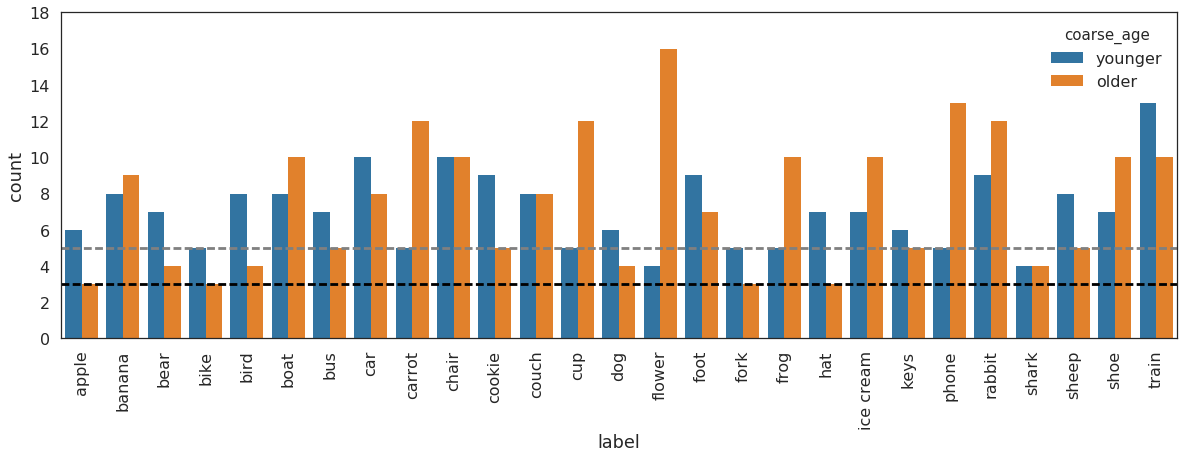

In [35]:
sns.set_context('poster')
plt.figure(figsize=(20,6))
sns.countplot(data=KM,
           x='label',
           hue='coarse_age')
labels = np.unique(KM.label.values)
h = plt.xticks(range(len(labels)), labels, fontsize=16,rotation='vertical')
plt.axhline(3,linestyle='dashed',color='black')
plt.axhline(5,linestyle='dashed',color='gray')
plt.ylim(0,18)
if not os.path.exists('./plots'):
    os.makedirs('./plots')
plt.savefig('./plots/drawing_counts_by_label_and_coarse_age.pdf')

In [36]:
## print list of classes for which we have "fewer than X" drawings in each age cohort and were thus excluded
thresh = 3
labels = np.unique(KM.label.values)
age_bins = ['younger','older']
labels_in_need = []
y_counter = []
o_counter = []
for lab in labels:
    y_count = sum(KM[KM['label']==lab]['coarse_age'] == 'younger')
    o_count = sum(KM[KM['label']==lab]['coarse_age'] == 'older')
    if (y_count<=thresh) | (o_count<=thresh):
        labels_in_need.append(lab)
        y_counter.append(y_count)
        o_counter.append(o_count)
o = pd.DataFrame([labels_in_need,y_counter,o_counter])
o = o.transpose()
o.columns = ['label','younger','older']
o = o.sort_values(by=['younger','older'],ascending=False)
o

,label,younger,older
3,hat,7,3
0,apple,6,3
1,bike,5,3
2,fork,5,3


### Extract adult drawing features

In [37]:
def load_adult_features(layer_ind,sufficient_data_labels):
    ## load in adult features
    AF, AM = load_features('adult',layer_ind)
    AF, AM = remove_practice_trials(AF, AM)
    AM = AM.reset_index(drop=True)

    ## set up lookup table to cover discrepancies in category label assignments
    lookup = dict(zip(these_labels,these_labels))
    if 'bike' in lookup.keys():
        lookup['bike'] = 'bicycle'

    ## subset adult feature matrix and metadata matrix by appropriate labelset
    AF, AM = subset_labels(AF, AM, [lookup[i] for i in these_labels])
    AM = AM.reset_index(drop=True)  
    
    return AF, AM

In [38]:
AF, AM = load_adult_features(6,sufficient_data_labels)

### Representational Similarity Analyses

In [39]:
## apply clustering to organize RDM so that we can see some block diagonal structure
def flatten(x):
    return [item for sublist in x for item in sublist]

## retrieve alpha sorted labels from meta
_labels = np.unique(AM.label.values)
means = get_class_means(AF, AM.label.values)
af = AffinityPropagation(damping=0.5).fit(means)
labels = af.labels_
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)

ordered_objs = []
print('Clusters')
for k in range(n_clusters_):
    class_members = labels == k
    print _labels[class_members]
    ordered_objs.append(list(_labels[class_members]))
    
ordered_objs = np.array(flatten(ordered_objs))

# define standard order to be used for RDM's across layers
standard_order = ordered_objs

## index for sorting the alphabetical list of labels INTO the order specified by ordered_objs (clustered)
sort_inds = [np.where(_labels==ordered_objs[i])[0][0] for i in np.arange(len(ordered_objs))]

Clusters
['apple']
['bus' 'car' 'train']
['carrot' 'chair' 'fork' 'ice cream']
['cookie']
['banana' 'bear' 'bicycle' 'bird' 'boat' 'dog' 'flower' 'frog' 'keys'
 'rabbit' 'shark' 'sheep']
['couch' 'cup' 'foot' 'hat' 'phone' 'shoe']


In [40]:
def get_and_plot_RDM(M,F,cohort,sort_inds):
    ## sorted adult RDMs
    labels = M.label.values
    means = get_class_means(F, labels)
    ordered_means = means[sort_inds,:]
    sns.set_style('white')
    CORRMAT = np.corrcoef(ordered_means)

    sns.set_context('paper')
    fig = plt.figure(figsize=(30,30))
    plt.matshow(1-CORRMAT, vmin=0, vmax=2)
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
    plt.yticks(range(len(ordered_objs)), ordered_objs); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False  
    RDM = CORRMAT
    plt.gcf().subplots_adjust(left=0.5) 
#     plt.tight_layout()    
    plt.savefig('./plots/RDM_{}.pdf'.format(cohort))
    return RDM

def showRDM(RDM,ordered_objs):
    sns.set_context('paper')
    fig = plt.figure(figsize=(30,30))
    plt.matshow(RDM, vmin=0, vmax=2)
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
    plt.yticks(range(len(ordered_objs)), ordered_objs); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False  

def get_RDM(M,F,sort_inds):
    ## sorted adult RDMs
    labels = M.label.values
    means = get_class_means(F, labels)
    ordered_means = means[sort_inds,:]    
    RDM = np.corrcoef(ordered_means)
    return RDM

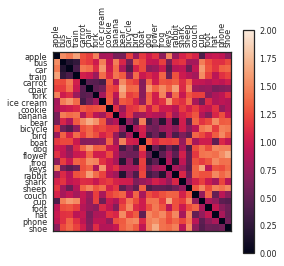

In [41]:
## get and plot sorted adult RDM
ARDM = get_and_plot_RDM(AM, AF,'adult',sort_inds)

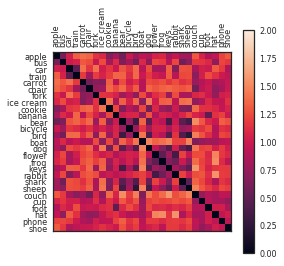

In [42]:
## get and plot sorted kid RDM collapsing across all ages
KRDM = get_and_plot_RDM(KM, KF,'kid',sort_inds)

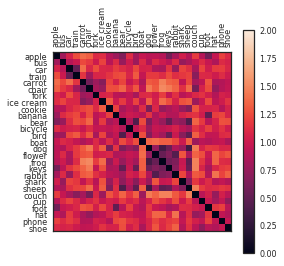

In [43]:
## get RDM for older kids (7,8,9,10)
ind = KM.index[KM['coarse_age'] == 'older']
meta = KM.loc[ind]
feat = KF[ind.tolist()]
ORDM = get_and_plot_RDM(meta, feat,'older',sort_inds)

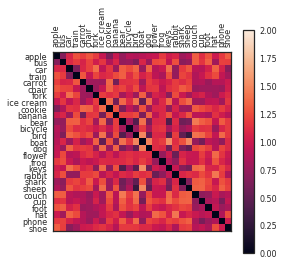

In [44]:
## get RDM for younger kids (3,4,5,6)
ind = KM.index[KM['coarse_age'] == 'younger']
meta = KM.loc[ind]
feat = KF[ind.tolist()]
YRDM = get_and_plot_RDM(meta, feat,'younger',sort_inds)

In [45]:
## print fc7 cross-cohort correlations

dim = KRDM.shape[0]
cor = stats.spearmanr(np.ravel(KRDM[np.triu_indices(dim,k=1)]),np.ravel(ARDM[np.triu_indices(dim,k=1)]))[0]
print 'Correlation between adult and overall kid RDM: {}'.format(cor)
print ' '
dim = ORDM.shape[0]
cor = stats.spearmanr(np.ravel(ORDM[np.triu_indices(dim,k=1)]),np.ravel(ARDM[np.triu_indices(dim,k=1)]))[0]
print 'Correlation between adult and OLDER kid RDM: {}'.format(cor)
print ' '
dim = YRDM.shape[0]
cor = stats.spearmanr(np.ravel(YRDM[np.triu_indices(dim,k=1)]),np.ravel(ARDM[np.triu_indices(dim,k=1)]))[0]
print 'Correlation between adult and YOUNGER kid RDM: {}'.format(cor)
print ' '
dim = YRDM.shape[0]
cor = stats.spearmanr(np.ravel(YRDM[np.triu_indices(dim,k=1)]),np.ravel(ORDM[np.triu_indices(dim,k=1)]))[0]
print 'Correlation between OLDER and YOUNGER kid RDM: {}'.format(cor)

Correlation between adult and overall kid RDM: 0.550771173271
 
Correlation between adult and OLDER kid RDM: 0.640146797647
 
Correlation between adult and YOUNGER kid RDM: 0.372084859585
 
Correlation between OLDER and YOUNGER kid RDM: 0.604570984571


### How does similarity differ across layers?

#### Set variables, paths, and define preprocessing functinos

In [46]:
## which label set are we using? common_labels or sufficient_data_labels
these_labels = sufficient_data_labels

## make sure directory for RDM exists
if not os.path.exists('./rdm'):
    os.makedirs('./rdm')

## function to apply various cleanup operations to adult feat/meta, including deborkifying and subsetting by appropriate labelset
def adult_preproc(AF, AM, these_labels):
    ## set up lookup table to cover discrepancies in category label assignments
    lookup = dict(zip(these_labels,these_labels))
    if 'bike' in lookup.keys():
        lookup['bike'] = 'bicycle'

    ## subset adult feature matrix and metadata matrix by appropriate labelset
    AF, AM = subset_labels(AF, AM, [lookup[i] for i in these_labels])
    AM = AM.reset_index(drop=True)    
    return AF, AM

## function to add coarse grain age and subset according to proper labelset
def preproc_kid(KF, KM,these_labels):    
    KM['coarse_age'] = KM.apply(coarse_grain_age, axis=1)
    ## subset labels that have at least some drawings of them from each age category
    younger_labels = KM[KM['coarse_age'] == 'younger']['label'].values
    older_labels = KM[KM['coarse_age'] == 'older']['label'].values
    
    ## subset to only use the labels with either COMMON LABELS or SUFFICIENT DATA (see cell above)
    KF, KM = subset_labels(KF, KM, these_labels)
    KM = KM.reset_index(drop=True)    
    return KF, KM


def get_RDM_resampled(M,F,sort_inds,iteration):
    ## sorted adult RDMs
    labels = M.label.values
    means = get_class_means(F, labels)
    ordered_means = means[sort_inds,:] 
    ### JACKKNIFE RESAMPLING OVER CLASSES (https://en.wikipedia.org/wiki/Jackknife_resampling)    
    # 1: exhaustively subset 15 of 16 categories, and compute cross-domain similarity in each case
    # 2: variance estimate = (n-1)/n  *   Sum([xi - x.i]^2)
    #          where x.i = (1/n) * Sum(xi), the average of all subsamples    
    jacks = np.roll(range(ordered_means.shape[0]),iteration)[:ordered_means.shape[0]-1]
    ordered_means = ordered_means[jacks,:]
    RDM = np.corrcoef(ordered_means)
    return RDM

def get_rdm_similarity(A,B):
    '''
    A is RDM for one population
    B is RDM for another population, of same dimensionality
    '''
    dim = A.shape[0]
    return stats.spearmanr(np.ravel(A[np.triu_indices(dim,k=1)]),np.ravel(B[np.triu_indices(dim,k=1)]))[0]

def subsample_rdm(RDM,i):
    '''
    If you have a 16 objects x 16 objects RDM, and want to remove one of the objects,
    yielding a 15x15 RDM, in order to compare to a jackknife RDM, apply this function.
    
    Generally speaking, it removes the i-th colum and row from the RDM.

    '''
    num_obj = RDM.shape[0]
    keep = sorted(np.roll(range(num_obj),i)[:num_obj-1])
    tmp = RDM[keep,:]
    tmp = tmp[:,keep]   
    return tmp



##### Generate and save out RDMs as separate npy files for adults

In [153]:
## subsampling on or off?
subsample_on = 0
# really run or not
really_run = 1

if really_run:
    for layer_num in np.arange(7):
        print 'Loading in adult features for layer {}...'.format(layer_num)
        AF, AM = load_features('adult',layer_num)
        AF, AM = remove_practice_trials(AF, AM)
        AM = AM.reset_index(drop=True)
        AF, AM = adult_preproc(AF, AM, these_labels)
        ## subsample features especially for lower layers
        if subsample_on:
            num_features = AF.shape[1]
            size_subsample = 100000
            if num_features>size_subsample:
                feat_inds = np.random.RandomState(0).permutation(num_features)[:size_subsample]
                AF = AF[:,feat_inds]         
        
        print 'Shape of adult feature tensor: {}'.format(np.shape(AF))

        ## get RDM
        cohort = 'adult'
        print 'Getting and saving RDM...'
        
        RDM = get_RDM(AM, AF,sort_inds)
        print np.shape(RDM)
        ## save out RDM as npy
        np.save('./rdm/RDM_{}_{}.npy'.format(cohort,layer_num),RDM) # was saving ADRM here, not RDM -- so not updating and was pulling last updated ADRM from above.
        
    print 'All done!'

Loading in adult features for layer 0...
Shape of adult feature tensor: (2700, 64)
Getting and saving RDM...
(27, 27)
Loading in adult features for layer 1...
Shape of adult feature tensor: (2700, 128)
Getting and saving RDM...
(27, 27)
Loading in adult features for layer 2...
Shape of adult feature tensor: (2700, 256)
Getting and saving RDM...
(27, 27)
Loading in adult features for layer 3...
Shape of adult feature tensor: (2700, 512)
Getting and saving RDM...
(27, 27)
Loading in adult features for layer 4...
Shape of adult feature tensor: (2700, 512)
Getting and saving RDM...
(27, 27)
Loading in adult features for layer 5...
Shape of adult feature tensor: (2700, 4096)
Getting and saving RDM...
(27, 27)
Loading in adult features for layer 6...
Shape of adult feature tensor: (2700, 4096)
Getting and saving RDM...
(27, 27)
All done!


##### Generate and save out RDMs as separate npy files for KIDS

In [158]:
## subsampling on or off?
subsample_on = 0
subsample_size = 100000
really_run = 0
lb = 0
ub = 7

if really_run:
    ## loop through all kid layers and save out their RDM
    for layer_num in np.arange(lb,ub):
        ## load in kid features
        KF, KM = load_features('kid',layer_num)
        KF, KM = remove_practice_trials(KF, KM)
        KM = KM.reset_index(drop=True)
        KF, KM = preproc_kid(KF, KM, these_labels)
        ## subsample features especially for lower layers
        if subsample_on:        
            num_features = KF.shape[1]
            size_subsample = subsample_size
            if num_features>size_subsample:
                feat_inds = np.random.RandomState(0).permutation(num_features)[:size_subsample]
                KF = KF[:,feat_inds]           
        print 'Shape of kid feature tensor: {}'.format(np.shape(KF))
        
        ## get RDM
        print 'Getting and saving RDM...'
        cohort = 'kid'
        KRDM = get_RDM(KM, KF,sort_inds)
        ## save out RDM as npy
        np.save('./rdm/RDM_{}_{}.npy'.format(cohort,layer_num),KRDM)
        
        print 'Saved OVERALL KID RDMs for layer {}!'.format(layer_num)        
                
    ## loop through all kid layers and save out their RDM
    for layer_num in np.arange(lb,ub):
        ## load in kid features
        KF, KM = load_features('kid',layer_num)
        KF, KM = remove_practice_trials(KF, KM)
        KM = KM.reset_index(drop=True)
        KF, KM = preproc_kid(KF, KM, these_labels)
        ## subsample features especially for lower layers
        if subsample_on:
            num_features = KF.shape[1]
            size_subsample = subsample_size
            if num_features>size_subsample:
                feat_inds = np.random.RandomState(0).permutation(num_features)[:size_subsample]
                KF = KF[:,feat_inds]              
        
        ## get RDM for older kids (7,8,9,10)
        ind = KM.index[KM['coarse_age'] == 'older']
        meta = KM.loc[ind]
        feat = KF[ind.tolist()]
        print 'Shape of older kid feature tensor: {}'.format(np.shape(feat))        
        ORDM = get_RDM(meta, feat,sort_inds)
        np.save('./rdm/RDM_{}_{}.npy'.format('older',layer_num),ORDM)            
        print 'Saved OLDER KID RDMs for layer {}!'.format(layer_num)        
            
    for layer_num in np.arange(lb,ub):
        ## load in kid features
        KF, KM = load_features('kid',layer_num)
        KF, KM = remove_practice_trials(KF, KM)
        KM = KM.reset_index(drop=True)
        KF, KM = preproc_kid(KF, KM, these_labels)
        ## subsample features especially for lower layers
        if subsample_on:
            num_features = KF.shape[1]
            size_subsample = subsample_size
            if num_features>size_subsample:
                feat_inds = np.random.RandomState(0).permutation(num_features)[:size_subsample]
                KF = KF[:,feat_inds]         
                        
        ## get RDM for younger kids (3,4,5,6)            
        ind = KM.index[KM['coarse_age'] == 'younger']
        meta = KM.loc[ind]
        feat = KF[ind.tolist()]
        print 'Shape of younger kid feature tensor: {}'.format(np.shape(feat))                
        YRDM = get_RDM(meta, feat,sort_inds)
        np.save('./rdm/RDM_{}_{}.npy'.format('younger',layer_num),YRDM)             
        print 'Saved YOUNGER KID RDMs for layer {}!'.format(layer_num)
                

##### Compute and plot layer-wise cross-cohort similarity (first without error bars)

In [147]:
np.shape(O)

(27, 27)

In [155]:
## Compute layer-wise correlations using pre-computed RDMs
corOA = []
corYA = []
corKA = []

for layer_num in np.arange(7):
    print layer_num
    Y = np.load('./rdm/RDM_younger_{}.npy'.format(layer_num))
    O = np.load('./rdm/RDM_older_{}.npy'.format(layer_num))
    A = np.load('./rdm/RDM_adult_{}.npy'.format(layer_num))
    K = np.load('./rdm/RDM_kid_{}.npy'.format(layer_num))
    print  np.shape(A)
    
    dim = O.shape[0]
    rOA = stats.spearmanr(np.ravel(O[np.triu_indices(dim,k=1)]),np.ravel(A[np.triu_indices(dim,k=1)]))[0]
    rYA = stats.spearmanr(np.ravel(Y[np.triu_indices(dim,k=1)]),np.ravel(A[np.triu_indices(dim,k=1)]))[0]
    rKA = stats.spearmanr(np.ravel(K[np.triu_indices(dim,k=1)]),np.ravel(A[np.triu_indices(dim,k=1)]))[0]
    
    corOA.append(rOA)
    corYA.append(rYA)
    corKA.append(rKA)


0
(27, 27)
1
(27, 27)
2
(27, 27)
3
(27, 27)
4
(27, 27)
5
(27, 27)
6
(27, 27)


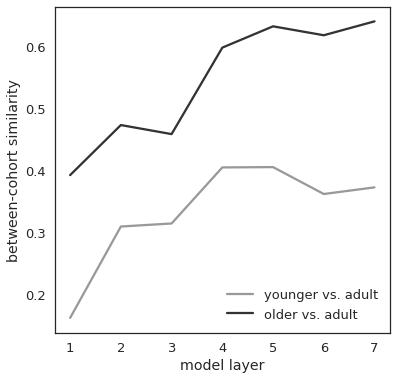

In [157]:
## Plot it
sns.set_context('talk')
sns.set_style('white')
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,8),corYA,label='younger vs. adult',color=(0.6,0.6,0.6))
plt.plot(np.arange(1,8),corOA,label='older vs. adult',color=(0.2,0.2,0.2))
# plt.plot(np.arange(1,8),corKA,label='all kids vs. adult',color=(0.6,0.2,0.2))
plt.xlabel('model layer')
plt.ylabel('between-cohort similarity')
plt.legend()
plt.savefig('./plots/btw_cohort_similarity.pdf')

#### Get errorbars for cross-cohort similarity plot (jackknife resampling over classes)

In [51]:
## which layers
lb = 0
ub = 7
nIter = len(these_labels)

reallyrun = 0
cohorts = ['younger','older']
CORMAT = []
if reallyrun:
    for cohort in cohorts:
        ## loop through all kid layers and save out their RDM
        Cormat = [] ## cohort-level grouping of cross-cohort similarity
        for layer_num in np.arange(lb,ub):
            print 'Loading in kid features for layer {}...'.format(layer_num)    
            ## load in kid features
            KF, KM = load_features('kid',layer_num)
            KF, KM = remove_practice_trials(KF, KM)
            KM = KM.reset_index(drop=True)
            KF, KM = preproc_kid(KF, KM, these_labels)
            print 'Shape of kid feature tensor: {}'.format(np.shape(KF))    

            print 'Loading in adult features for layer {}...'.format(layer_num)
            AF, AM = load_features('adult',layer_num)
            AF, AM = remove_practice_trials(AF, AM)
            AM = AM.reset_index(drop=True)
            AF, AM = adult_preproc(AF, AM, these_labels)
            print 'Shape of adult feature tensor: {}'.format(np.shape(KF))    

            ## subsample features especially for lower layers
            if subsample_on:
                num_features = AF.shape[1]
                size_subsample = 100000
                if num_features>size_subsample:
                    feat_inds = np.random.RandomState(0).permutation(num_features)[:size_subsample]
                    AF = AF[:,feat_inds]         

            print 'Shape of adult feature tensor: {}'.format(np.shape(AF)) 

            ## get older kid RDM
            print 'Getting and saving kid and adult RDMs ...'
            KRDM = []
            ARDM = []
            cormat = [] ## layer-level grouping of cross-cohort similarity
            for i in range(nIter):
                print 'Iteration {} of {}'.format(i,nIter)
                ## get RDM for this cohort, i.e., {'older', 'younger'}
                ind = KM.index[KM['coarse_age'] == cohort]
                meta = KM.loc[ind]
                feat = KF[ind.tolist()]                    
                krdm = get_RDM_resampled(meta, feat,sort_inds,i)
                ## get RDM adult for adults, aggregate across iterations
                ardm = get_RDM_resampled(AM, AF,sort_inds,i)        
                if len(KRDM)==0:
                    KRDM = krdm
                    ARDM = ardm
                else:
                    KRDM = np.dstack((KRDM,krdm))
                    ARDM = np.dstack((ARDM,ardm))                                  
                ## compute similarity between RDMs
                cormat.append(get_rdm_similarity(krdm,ardm))
            ## layer level aggregation    
            Cormat.append(cormat)
            KRDM = np.array(KRDM)
            ARDM = np.array(ARDM)
            np.save('./rdm/RDM_jackknife_{}_{}.npy'.format(cohort,layer_num),KRDM)             
            np.save('./rdm/RDM_jackknife_{}_{}.npy'.format('adult',layer_num),ARDM)         
        ## cohort level aggregation    
        CORMAT.append(Cormat)
        
        ## save CORMAT 
        CORMAT = np.array(CORMAT)
        np.save('./rdm/CORMAT.npy',CORMAT)

                  

In [159]:
#  Load CORMAT if we didn't just compute it 
CORMAT = np.load('./rdm/CORMAT.npy')
## CORMAT has dimensionality: num_cohorts x num_layers x num_objects
num_categories = np.shape(np.array(CORMAT))[2]
np.shape(np.array(CORMAT)) 


(2, 7, 27)

### Compute jacknife SEM based on simulations

In [160]:

## JACKKNIFE RESAMPLING OVER CLASSES (https://en.wikipedia.org/wiki/Jackknife_resampling)    
# 1: exhaustively subset 15 of 16 categories, and compute cross-domain similarity in each case
# 2: variance estimate = (n-1)/n  *   Sum([xi - x.i]^2)
#          where x.i = (1/n) * Sum(xi), the average of all subsamples 
cohorts = ['younger','older']
SEM_JACK = []

for c,cohort in enumerate(cohorts):
    sem_jack = []
    for layer_num in np.arange(7):
        jackvals = CORMAT[c,layer_num,:]
        jackmean = np.mean(jackvals)
        sem_jack.append(np.sqrt( (num_categories-1)/(num_categories) * np.array([(i-jackmean)**2 for i in jackvals]).sum()))
    SEM_JACK.append(sem_jack)
SEM_JACK = np.array(SEM_JACK)

In [161]:
### Make layer-wise plot now with errorbars

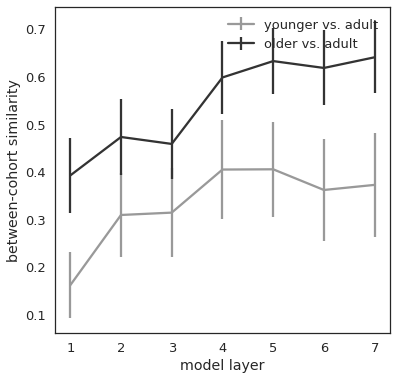

In [162]:
## dimensionality of SEM_JACK is num_cohorts x num_layers
sem_ya = SEM_JACK[0,:]
sem_oa = SEM_JACK[1,:]

##
sns.set_context('talk')
sns.set_style('white')
plt.figure(figsize=(6,6))
h = plt.errorbar(np.arange(1,8),corYA,yerr=[sem_ya,sem_ya], color=[0.6, 0.6, 0.6], ecolor=[0.6, 0.6, 0.6],label='younger vs. adult')
h = plt.errorbar(np.arange(1,8),corOA,yerr=[sem_oa,sem_oa], color=[0.2, 0.2, 0.2], ecolor=[0.2, 0.2, 0.2],label='older vs. adult')
plt.xlabel('model layer')
plt.ylabel('between-cohort similarity')
plt.legend()
plt.savefig('./plots/btw_cohort_similarity.pdf')

In [56]:
## save out cohort similarity csv for plotting in R
df = pd.DataFrame({
    'CorrYoungAdult':  corYA,
    'SEMYoungAdult':sem_ya,
    'CorrOldAdult':  corOA,
    'SEMOldAdult':  sem_oa,
})
df.to_csv('./rdm/CohortSimilarity.csv') 

### Compute adult-adult noise ceiling

In [140]:
## How many sketches do we have from each class in kids? Take this number, divide by 2, to get approx number 
## in adults for consistency analysis. Divide by 2, because we already are dividing kid drawing dataset
## into younger and older subcategories.

## edit Jan 30 2018: Bria asked about estimating adult-adult consistency in a way that is 
## directly comparable in terms of dataset size to the kid-adult RDM correlations.
## so to do this, we will estimate an RDM based on correlating noisy sub-sampled adult with 
## same rock-solid adult RDM on every go.

## load in kid dataset in order to get num kid drawings per class
YF, YM = load_features('kid',6)
kid_num_per_class = zip(np.unique(YM.label.values),np.round(YM.groupby('label').count()['age'].values/2))
knpc = dict(kid_num_per_class)
knpc['bicycle'] = knpc.pop('bike') # deal with naming inconsistency

## load in adult features by layer and get internal consistency
CORR = [] ## overall 
CORR2 = []
first_layer = 0
num_layers = 7

for layer_num in np.arange(first_layer,num_layers):
    print('Layer {} of {}'.format(layer_num,num_layers))
    AF, AM = load_features('adult',layer_num)    
    AF, AM = remove_practice_trials(AF, AM)
    AM = AM.reset_index(drop=True)
    AF, AM = adult_preproc(AF, AM, these_labels)    
    qats = np.unique(AM.label.values)
    nIter = 10

    Cor = [] ## correlation between split RDM's
    Cor2 = [] ## correlation between small RDM and noisy RDM
    
    ## load in rock-solid RDM estimated on 100 drawings per class
    adult_rock_RDM = []
#     adult_rock_RDM = np.load('./rdm/RDM_adult_{}.npy'.format(layer_num) ## BLL:  this was also before the layer_num loop
    adult_rock_RDM = get_RDM(AM,AF,sort_inds) ## BLL changed here -- the saved features were actually all FC7 features
                             
    for it in np.arange(nIter):
        Meta = [] # initialize adult subsampled metadata csv -- same for both halves
        Feat1 = [] # initialize adult subsampled feature matrix -- constitutes first half
        Feat2 = [] # initialize adult subsampled feature matrix -- constitutes second half
        if it%5==0:
            print('Iteration {} of {}'.format(it,nIter))
        for q in qats:
            ind = AM.index[AM['label'] == q] # get indexes
            meta = AM.loc[ind] # get metadata for this category
            meta = meta.reset_index(drop=True)
            feat = AF[ind.tolist()] # get features for this category
            how_many = int(knpc[q]) ## look up approx(!) how many younger/older kid sketches we have from this class

            ## Randomly sample
            row_inds = np.random.RandomState(it).permutation(meta.shape[0])[:how_many]
            metasamp = meta.loc[row_inds]
            featsamp = feat[row_inds.tolist()] ## subsample first "split-half" feature mat

            row_inds_2 = np.random.RandomState(it).permutation(meta.shape[0])[how_many*2:how_many*3] ## get the next drawings in the permuted list
            featsamp2 = feat[row_inds_2.tolist()] ## subsample second "split-half" feature mat
            metasamp2 = meta.loc[row_inds_2]

            if len(Meta)==0:        
                Meta = metasamp
                Meta2 = metasamp2
                Feat1 = featsamp
                Feat2 = featsamp2
            else:
                Meta = pd.concat((Meta,metasamp))
                Meta2 = pd.concat((Meta2,metasamp2))
                Feat1 = np.vstack((Feat1,featsamp)) 
                Feat2 = np.vstack((Feat2,featsamp2))
            
        ## get class means        
        Meta = Meta.reset_index(drop=True)
        Meta2 = Meta2.reset_index(drop=True)
        print np.shape(Feat1)
        means1 = get_class_means(Feat1, Meta.label.values)
        means2 = get_class_means(Feat2, Meta2.label.values)

        ## get RDM for each half
        print np.shape(Meta)
        print np.shape(Feat2)
        rdm1 = get_RDM(Meta,Feat1,sort_inds)
        rdm2 = get_RDM(Meta,Feat2,sort_inds)
                
        dim = rdm1.shape[0]
        cor = stats.spearmanr(np.ravel(rdm1[np.triu_indices(dim,k=1)]), \
                              np.ravel(adult_rock_RDM[np.triu_indices(dim,k=1)]))[0]
        cor2 = stats.spearmanr(np.ravel(rdm1[np.triu_indices(dim,k=1)]), \
                              np.ravel(rdm2[np.triu_indices(dim,k=1)]))[0]
        Cor.append(cor)
        Cor2.append(cor2)
    CORR.append(Cor)
    CORR2.append(Cor2)

Layer 0 of 7
Iteration 0 of 10
(196, 64)
(196, 3)
(196, 64)
(196, 64)
(196, 3)
(196, 64)
(196, 64)
(196, 3)
(196, 64)
(196, 64)
(196, 3)
(196, 64)
(196, 64)
(196, 3)
(196, 64)
Iteration 5 of 10
(196, 64)
(196, 3)
(196, 64)
(196, 64)
(196, 3)
(196, 64)
(196, 64)
(196, 3)
(196, 64)
(196, 64)
(196, 3)
(196, 64)
(196, 64)
(196, 3)
(196, 64)
Layer 1 of 7
Iteration 0 of 10
(196, 128)
(196, 3)
(196, 128)
(196, 128)
(196, 3)
(196, 128)
(196, 128)
(196, 3)
(196, 128)
(196, 128)
(196, 3)
(196, 128)
(196, 128)
(196, 3)
(196, 128)
Iteration 5 of 10
(196, 128)
(196, 3)
(196, 128)
(196, 128)
(196, 3)
(196, 128)
(196, 128)
(196, 3)
(196, 128)
(196, 128)
(196, 3)
(196, 128)
(196, 128)
(196, 3)
(196, 128)
Layer 2 of 7
Iteration 0 of 10
(196, 256)
(196, 3)
(196, 256)
(196, 256)
(196, 3)
(196, 256)
(196, 256)
(196, 3)
(196, 256)
(196, 256)
(196, 3)
(196, 256)
(196, 256)
(196, 3)
(196, 256)
Iteration 5 of 10
(196, 256)
(196, 3)
(196, 256)
(196, 256)
(196, 3)
(196, 256)
(196, 256)
(196, 3)
(196, 256)
(196,

In [166]:
## save out average values & rename variables
adult_noisy_rock_layerwise = np.asarray(CORR)
adult_noisy_noisy_layerwise = np.asarray(CORR2)
np.save('./rdm/adult_noisy_rock_layerwise.npy',adult_noisy_rock_layerwise)  
np.save('./rdm/adult_noisy_noisy_layerwise.npy',adult_noisy_noisy_layerwise)  

adult_noisy_rock_layerwise.mean(1)


array([ 0.76601099,  0.8309798 ,  0.82619605,  0.87495788,  0.82177781,
        0.78190246,  0.80623113])

### Jackknife resampling on class for noisy adult

In [92]:
###### jackknife resampling on class for noisy adult -- rock-solid adult RDM similarity
lb = 0
ub = 7
nIter = len(these_labels)
Cormat = [] 

for layer_num in np.arange(lb,ub):
    ARDM = [] 
    NARDM = []
    
    ### loading in all adult features
    print 'Loading in adult features for layer {}...'.format(layer_num)
    AF, AM = load_features('adult',layer_num)
    AF, AM = remove_practice_trials(AF, AM)
    AM = AM.reset_index(drop=True)
    AF, AM = adult_preproc(AF, AM, these_labels)
    print 'Shape of adult feature tensor: {}'.format(np.shape(AF)) 

    ## get categories
    qats = np.unique(AM.label.values)
    nIter = 1

    Cor = [] ## correlation between split RDM's
    for it in np.arange(nIter):
        Meta = [] # initialize adult subsampled metadata csv -- same for both halves
        Feat1 = [] # initialize adult subsampled feature matrix -- constitutes first half
        Feat2 = [] # initialize adult subsampled feature matrix -- constitutes second half
        if it%5==0:
            print('Iteration {} of {}'.format(it,nIter))
        for q in qats:
            ind = AM.index[AM['label'] == q]
            meta = AM.loc[ind]
            meta = meta.reset_index(drop=True)
            feat = AF[ind.tolist()]

            how_many = int(knpc[q]) ## look up approx(!) how many younger/older kid sketches we have from this class
            row_inds = np.random.RandomState(it).permutation(meta.shape[0])[:how_many]
            metasamp = meta.loc[row_inds]
            featsamp = feat[row_inds.tolist()] ## subsample first "split-half" feature mat

            if len(Meta)==0:
                Meta = metasamp
                Feat1 = featsamp
            else:
                Meta = pd.concat((Meta,metasamp))
                Feat1 = np.vstack((Feat1,featsamp)) 

        ## define feature matrix and metadata         
        NAM = Meta.reset_index(drop=True)
        NAF = Feat1
        print 'Shape of adult feature tensor: {}'.format(np.shape(NAF)) 

        ## jackknife resample through classes
        print 'Performing jackknife resampling ...'
        ARDM = []
        NARDM = []
        cormat = [] ## layer-level grouping of cross-cohort similarity
        num_cats = 27
        for i in range(num_cats):
            if i%4==0:
                print 'Iteration {} of {}'.format(i,num_cats)

            ## get RDM adult for adults, aggregate across iterations
            nardm = get_RDM_resampled(NAM, NAF,sort_inds,i) 
            ardm = get_RDM_resampled(AM,AF,sort_inds,i)
            if len(ARDM)==0:
                ARDM = ardm
                NARDM = nardm
            else:
                ARDM = np.dstack((ARDM,ardm))   
                NARDM = np.dstack((NARDM,nardm)) 
                
            ## compute similarity between noisy-adult RDM and rock-solid RDM                                                
            cormat.append(get_rdm_similarity(nardm,ardm))
            
        ## layer level aggregation    
        Cormat.append(cormat)
        ARDM = np.array(ARDM)  
        NARDM = np.array(NARDM)
        
        ## save out jackknifed RDM        
        np.save('./rdm/RDM_jackknife_{}_{}.npy'.format('noisy_adult',layer_num),NARDM)  
        np.save('./rdm/RDM_jackknife_{}_{}.npy'.format('adult_micro',layer_num),ARDM)

Cormat = np.array(Cormat)                      

Iteration 20 of 27
Iteration 24 of 27
Loading in adult features for layer 6...
Shape of adult feature tensor: (2700, 4096)
Iteration 0 of 1
Shape of adult feature tensor: (196, 4096)
Performing jackknife resampling ...
Iteration 0 of 27
Iteration 4 of 27
Iteration 8 of 27
Iteration 12 of 27
Iteration 16 of 27
Iteration 20 of 27
Iteration 24 of 27


#### Recreate averages and sems from jacknifed samples


In [184]:

lb = 0
up = 7
iteration = 27
# intialize
older_younger = np.zeros((up,iteration))
noisy_micro = np.zeros((up,iteration))
older_noisy_adult = np.zeros((up,iteration))
younger_noisy_adult = np.zeros((up,iteration))
older_micro_adult = np.zeros((up,iteration))
younger_micro_adult = np.zeros((up,iteration))

for layer_num in np.arange(lb,ub):
    YRDM = np.load('./rdm/RDM_jackknife_younger_{}.npy'.format(layer_num))
    ORDM = np.load('./rdm/RDM_jackknife_older_{}.npy'.format(layer_num))
    NARDM = np.load('./rdm/RDM_jackknife_noisy_adult_{}.npy'.format(layer_num))
    ARDM = np.load('./rdm/RDM_jackknife_adult_micro_{}.npy'.format(layer_num))
    
    for iteration in np.arange(0,27):
        yrdm = YRDM[:,:,iteration]
        ordm = ORDM[:,:,iteration]
        nardm = NARDM[:,:,iteration]
        ardm = ARDM[:,:,iteration]
        
        older_younger[layer_num, iteration] = get_rdm_similarity(yrdm,ordm)
        noisy_micro[layer_num, iteration] = get_rdm_similarity(ardm,nardm)
        
        older_noisy_adult[layer_num, iteration] = get_rdm_similarity(ordm,nardm)
        younger_noisy_adult[layer_num, iteration] = get_rdm_similarity(yrdm,nardm)
        
        older_micro_adult[layer_num, iteration] = get_rdm_similarity(ordm,ardm)
        younger_micro_adult[layer_num, iteration] = get_rdm_similarity(yrdm,ardm)
        
def get_jacknife_sem(cormat,num_categories):
    sem_jack = []
    for layer_num in np.arange(7):
        jackvals = cormat[layer_num,:]
        jackmean = np.mean(jackvals)
        sem_jack.append(np.sqrt( (num_categories-1)/(num_categories) * np.array([(i-jackmean)**2 for i in jackvals]).sum()))
    sem_jack=np.asarray(sem_jack)
    return sem_jack

num_categories = 27
older_younger_sem = get_jacknife_sem(older_younger,num_categories)
noisy_micro_sem = get_jacknife_sem(noisy_micro,num_categories)   
older_noisy_adult_sem = get_jacknife_sem(older_noisy_adult,num_categories)   
younger_noisy_adult_sem = get_jacknife_sem(younger_noisy_adult,num_categories)   
older_micro_adult_sem = get_jacknife_sem(older_micro_adult,num_categories)   
younger_micro_adult_sem = get_jacknife_sem(younger_micro_adult,num_categories)   

#### Make diagnostic plots

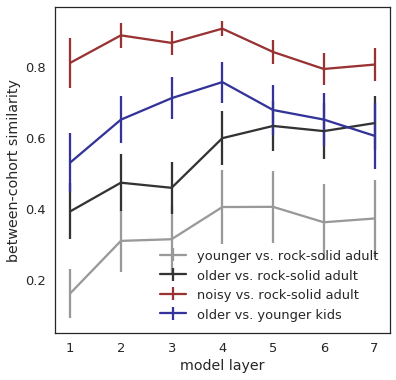

In [185]:
sns.set_context('talk')
sns.set_style('white')
plt.figure(figsize=(6,6))

# kids vs rock adults
h = plt.errorbar(np.arange(1,8),younger_micro_adult.mean(1),yerr=[younger_micro_adult_sem,younger_micro_adult_sem], color=[0.6, 0.6, 0.6], ecolor=[0.6, 0.6, 0.6],label='younger vs. rock-solid adult')
h = plt.errorbar(np.arange(1,8),older_micro_adult.mean(1),yerr=[older_micro_adult_sem,older_micro_adult_sem], color=[0.2, 0.2, 0.2], ecolor=[0.2, 0.2, 0.2],label='older vs. rock-solid adult')

# kids vs noisy adults
# h = plt.errorbar(np.arange(1,8),younger_noisy_adult.mean(1),yerr=[younger_noisy_adult_sem,younger_noisy_adult_sem], color=[0.6, 0.6, 0.8], ecolor=[0.6, 0.6, 0.8],label='younger vs. noisy adult')
# h = plt.errorbar(np.arange(1,8),older_noisy_adult.mean(1),yerr=[older_noisy_adult_sem,older_noisy_adult_sem], color=[0.2, 0.2, 0.2], ecolor=[0.2, 0.2, 0.4],label='older vs. noisy adult')

# adults v adults
h = plt.errorbar(np.arange(1,8),noisy_micro.mean(1),yerr=[noisy_micro_sem,noisy_micro_sem], color=[0.6, 0.2, 0.2], ecolor=[0.6, 0.2, 0.2],label='noisy vs. rock-solid adult')

# younger vs older kids
h = plt.errorbar(np.arange(1,8),older_younger.mean(1),yerr=[older_younger_sem,older_younger_sem], color=[0.2, 0.2, 0.6], ecolor=[0.2, 0.2, 0.6],label='older vs. younger kids ')


plt.xlabel('model layer')
plt.ylabel('between-cohort similarity')
plt.legend()

0.6435184311257931

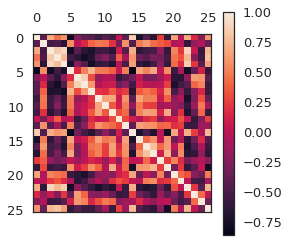

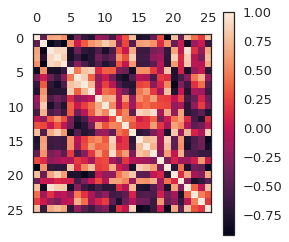

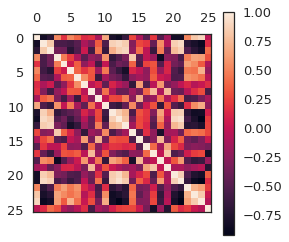

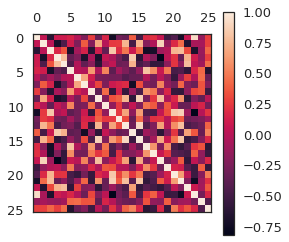

In [61]:
plt.matshow(NARDM_1[:,:,1])
plt.colorbar()

plt.matshow(ARDM_1[:,:,1])
plt.colorbar()

plt.matshow(YRDM_1[:,:,1])
plt.colorbar()

plt.matshow(ORDM_1[:,:,1])
plt.colorbar()

In [ ]:
# ## this is a (7,10) matrix that is num_layers x numIterations
# x = np.load('./rdm/adult_split_reliability_by_layer.npy')
# noisy_adult_6 = np.load('./rdm/RDM_jackknife_noisy_adult_6.npy')

In [ ]:
# ## load in kid features by layer and get consistency
# CORR = [] ## overall 
# first_layer = 0
# num_layers = 7
# cohorts = ['younger','older']

# for cohort in cohorts:
#     for layer_num in np.arange(first_layer,num_layers):
#         print('Layer {} of {}'.format(layer_num,num_layers))
#         KF, KM = load_features('kid',layer_num)

#         qats = np.unique(KM.label.values)
#         Meta = [] # initialize adult subsampled metadata csv -- same for both halves
#         Feat1 = [] # initialize adult subsampled feature matrix -- constitutes first half
#         Feat2 = [] # initialize adult subsampled feature matrix -- constitutes second half

#         nIter = 10

#         Cor = [] ## correlation between split RDM's
#         for it in np.arange(nIter):
#             if it%5==0:
#                 print('Iteration {} of {}'.format(it,nIter))
#             for q in qats:
#                 ind = KM.index[(KM['label'] == q) & (KM['coarse_age']==cohort)]
#                 meta = KM.loc[ind]
#                 meta = meta.reset_index(drop=True)
#                 feat = KF[ind.tolist()]

#                 how_many = np.floor(meta.shape[0]/2)

#                 row_inds = np.random.RandomState(it).permutation(meta.shape[0])[:how_many]
#                 metasamp = meta.loc[row_inds]
#                 featsamp = feat[row_inds.tolist()] ## subsample first "split-half" feature mat

#                 row_inds_2 = np.random.RandomState(it).permutation(meta.shape[0])[how_many:how_many*2] ## get the next drawings in the permuted list
#                 featsamp2 = feat[row_inds_2.tolist()] ## subsample second "split-half" feature mat

#                 if len(Meta)==0:
#                     Meta = metasamp
#                     Feat1 = featsamp
#                     Feat2 = featsamp2
#                 else:
#                     Meta = pd.concat((Meta,metasamp))
#                     Feat1 = np.vstack((Feat1,featsamp)) 
#                     Feat2 = np.vstack((Feat2,featsamp2))

#             ## get class means        
#             Meta = Meta.reset_index(drop=True)
#             means1 = get_class_means(Feat1, Meta.label.values)
#             means2 = get_class_means(Feat2, Meta.label.values)

#             ## get RDM for each half
#             rdm1 = get_RDM(Meta,Feat1,sort_inds)
#             rdm2 = get_RDM(Meta,Feat2,sort_inds)

#             dim = rdm1.shape[0]
#             cor = stats.spearmanr(np.ravel(rdm1[np.triu_indices(dim,k=1)]),np.ravel(rdm2[np.triu_indices(dim,k=1)]))[0]
#             Cor.append(cor)
#         CORR.append(Cor)

In [ ]:
# CORR = np.array(CORR)
# np.save('./rdm/kid_split_reliability_by_layer.npy',CORR)

In [ ]:
y = x.mean(1)

In [ ]:
### notes 1/22/18:
## preprocessing -- bounding box, remove drawings that have 0 mean pixel intensity, have text in them
  ## make invalid sketches file
## make human vs. model confusion matrix?
## make adult -- grab 5 per class "split-half" reliability -- but can actually just take two wholes, and correlate them
## estimate kids' variability -- within-class as well as across class.

In [ ]:
### check preprocessing on images
### older-younger consistency
### pixel rdm similarity
### variance within classes 

In [ ]:
# ####  Classification test -- all children
# FEAT = KF
# LABELS = KM.label.values
# AGES = KM.age.values

# # single train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     FEAT, LABELS, test_size=0.25, random_state=0)
# # clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train) # ? not used, leaving for future use
# clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)
# print clf.score(X_test, y_test)

# run_this = 0
# if run_this:
#     # cross-validated
#     clf = linear_model.LogisticRegression(penalty='l2')
#     scores = cross_val_score(clf, FEAT, LABELS, cv=3)
#     print("All children accuracy: %0.2f (SD = %0.2f)" % (scores.mean(), scores.std())) # not sure why multiplying by 2, reporting just SD for now

In [ ]:
# ####  Classification test -- older children
# FEAT = KF_older
# LABELS = KM_older.label.values
# AGES = KM_older.age.values

# # single train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     FEAT, LABELS, test_size=0.25, random_state=0)
# clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)
# print clf.score(X_test, y_test)

# run_this = 0
# if run_this:
#     # cross-validated
#     clf = linear_model.LogisticRegression(penalty='l2')
#     scores = cross_val_score(clf, FEAT, LABELS, cv=3)
#     print("Older children: accuracy: %0.2f (SD = %0.2f)" % (scores.mean(), scores.std())) # not sure why multiplying by 2, reporting just SD for now
    

In [ ]:
# #### Quick classification test -- younger children
# FEAT = KF_younger
# LABELS = KM_younger.label.values
# AGES = KM_younger.age.values

# # single train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     FEAT, LABELS, test_size=0.25, random_state=0)
# clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)
# print clf.score(X_test, y_test)

# run_this = 0
# if run_this:
#     # cross-validated
#     clf = linear_model.LogisticRegression(penalty='l2')
#     scores = cross_val_score(clf, FEAT, LABELS, cv=3)
#     print("Younger children: accuracy: %0.2f (SD = %0.2f)" % (scores.mean(), scores.std())) # not sure why multiplying by 2, reporting just SD for now
    


In [ ]:
## Classification tests -- older vs. younger

In [ ]:
# ## see how recognizability changes with age?
# scores = []
# num_samples = []
# age_range = np.arange(4,11)

# # width of moving window in # of trials    
# window_size = 4
# lb = int(min(KM.age.values))
# ub = int(max(KM.age.values))
# num_windows = ub-lb-window_size+2 ##     

# for n in np.arange(num_windows):
#     start = lb + n
#     end = lb + n + window_size
#     ind = KM.index[(KM['age'] >= start) & (KM['age'] < end)]
#     meta = KM.loc[ind]
#     subFeat = KF[ind.tolist()]

#     FEAT = subFeat
#     LABELS = meta.label.values

#     # single train/test split
#     X_train, X_test, y_train, y_test = train_test_split(
#         FEAT, LABELS, test_size=0.25, random_state=3)
#     clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
# #     clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)
#     print '{}-{}y'.format(start, end-1), len(LABELS),clf.score(X_test, y_test)
#     num_samples.append(len(LABELS))
#     scores.append(clf.score(X_test, y_test))

In [ ]:
## not finished -- want to get subsample to get comparable classification

# categoryFeaturesOut=np.zeros((numSampled*numClasses,np.shape(AF)[1])) 
# np.shape(categoryFeaturesOut[0:10,:])
# def get_adult_subsample(AF,AM):
#     uniqueLabels=np.unique(AM.label.values)
#     labels=AM.label.values
#     categoryFeaturesOut=np.zeros((numSampled*numClasses,np.shape(AF)[1])) 
#     print np.shape(categoryFeaturesOut)
#     for vi, v in enumerate(np.asarray(uniqueLabels)):
#         categoryFeatures # clear to be sure
#         catIndexStart=(vi)*numSampled
#         catIndexEnd=catIndexStart+numSampled
#         print catIndexStart
#         print catIndexEnd
#         randImageInd=np.random.randint(500,size=numSampled)
#         categoryFeatures=AF[labels == v,:]
#         categoryFeaturesSelected=categoryFeatures[randImageInd,:]
        
#         np.shape(categoryFeatures)
#         return categoryFeatures
#         del categoryFeatures category       

# categoryFeatures=get_adult_subsample(AF,AM)
# categoryFeatures


In [ ]:
### Correlations between features in FC7 each class (e.g., object category)

In [ ]:
# reallyRun = 0
# if reallyRun:
#     # make general function
#     def corr_cohort_classes(cohort1,cohort2,uniqueLabels):
#         if  np.shape(cohort1)==np.shape(cohort2): ## make sure same shape
#             classCor=np.zeros(np.shape(uniqueLabels)[0]) # open variable
#             for vi, v in enumerate(np.asarray(uniqueLabels)):
#                 cohort1Vec = cohort1[uniqueLabels == v,:]
#                 cohort2Vec = cohort2[uniqueLabels == v,:]
#                 cohort1Vec=np.reshape(cohort1Vec,np.shape(cohort1Vec)[1],np.shape(cohort1Vec)[0]) # resahpe for corr
#                 cohort2Vec=np.reshape(cohort2Vec,np.shape(cohort2Vec)[1],np.shape(cohort2Vec)[0])# resahpe for corr
#                 classCor[vi]=stats.pearsonr(cohort1Vec,cohort2Vec)[0]
#             return classCor

#     uniqueLabels=np.unique(KM.label.values)
#     means_adult = get_class_means(AF, AM.label.values)
#     means_kid = get_class_means(KF, KM.label.values)
#     classCor=corr_cohort_classes(means_adult,means_kid,np.unique(KM.label.values))
#     sortInd=np.argsort(classCor)
#     print uniqueLabels[sortInd]
#     print classCor[sortInd]
    
#     means_older = get_class_means(KF_older, KM_older.label.values)
#     means_younger = get_class_means(KF_younger, KM_younger.label.values)    
    
#     classCor_Younger=corr_cohort_classes(means_adult,means_younger,np.unique(KM.label.values))
#     sortIndYounger=np.argsort(classCor_Younger)

#     classCor_Older=corr_cohort_classes(means_adult,means_older,np.unique(KM.label.values))
#     sortIndOlder=np.argsort(classCor_Older)

#     df = pd.DataFrame({
#         'Labels-Older':  uniqueLabels[sortIndOlder],
#         'Correlations-Older': classCor_Older[sortIndOlder],
#         'Labels-Younger': uniqueLabels[sortIndYounger],
#         'Correlations-Younger': classCor_Younger[sortIndYounger],
#         'Labels-AllKids':uniqueLabels[sortInd],
#         'Correlations-AllKids':classCor[sortInd],
#     })
#     df.to_csv('FeatureCorrelationsByClass.csv') # save for me to load into R!    